In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
house_df_org = pd.read_csv('~/git/MLguide/house_train.csv')
house_df = house_df_org.copy()
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print(house_df.shape)
print(house_df.info())

(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st     

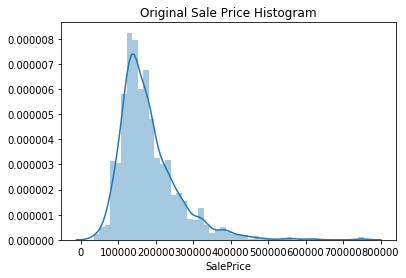

In [4]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

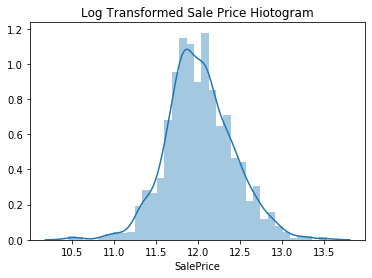

In [5]:
plt.title('Log Transformed Sale Price Hiotogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [6]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

# 드롭하지 않은 숫자형 Null칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# Null값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print(null_column_count)

MasVnrType       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
GarageType      81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64


In [7]:
# one-hot encoding for object type
house_df_ohe = pd.get_dummies(house_df)

In [8]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.1318957657915438, 0.1275084633405305, 0.17628250556471395]

In [10]:
def get_top_bottom_coef(model, n=10):
    # coef 속성을 기반으로 Series객체를 생성. index는 칼럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # +상위 10개, -하위 10개의 회귀 계수를 추출해 반환.
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

In [11]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()
    # 입력 인자로 받은 list객체인 models에서 차례로 model를 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        # 상위10개, 하위10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font크기 조정.
        axs[i_num].set_title(model.__class__.__name__+'Coefficients', size=25)
        axs[i_num].tick_params(axis="y", direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

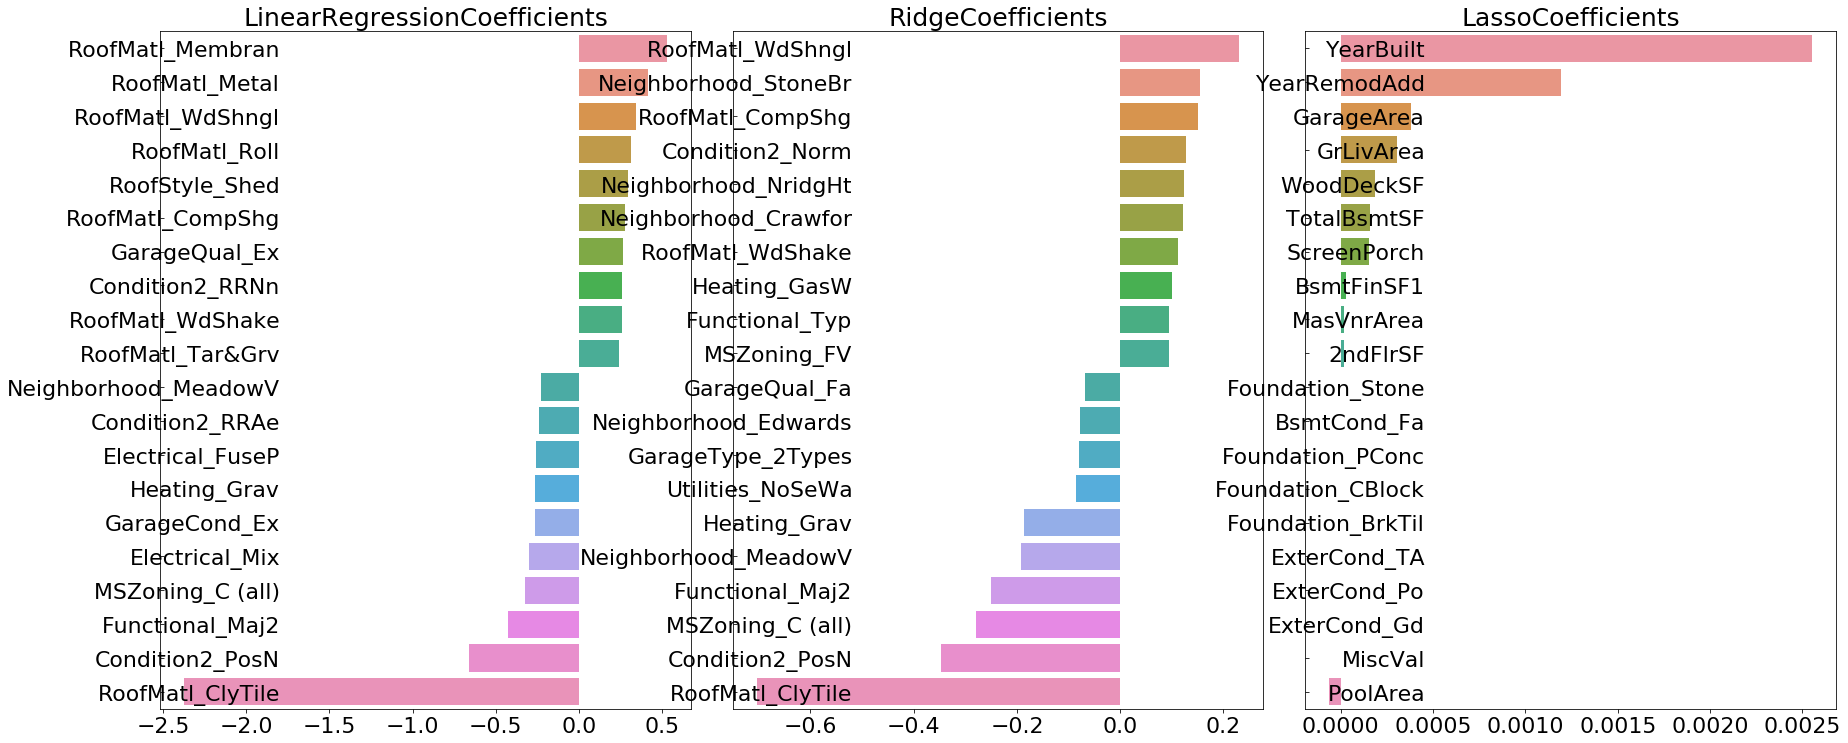

In [12]:
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

위에서 라쏘만 회귀계수 값이 매우 작고 YearBuilt가 가장 크면서 나머지는 너무 작다. 그래서 분할 문제가 있어서 그런건 아닌지 확인한다.

In [13]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                            scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print(model.__class__.__name__, np.round(rmse_list, 3))
        print(model.__class__.__name__, np.round(rmse_avg, 3))

models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)      

LinearRegression [0.135 0.165 0.168 0.111 0.198]
LinearRegression 0.155
Ridge [0.117 0.154 0.142 0.117 0.189]
Ridge 0.144
Lasso [0.161 0.204 0.177 0.181 0.265]
Lasso 0.198


아직도 라쏘의 성능이 좋지 않은 것을 확인 할 수 있다. 자 이제 파라미터 조정을 좀 해보자.

In [14]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                             scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_)
    
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 0.1418 {'alpha': 12}
Lasso 0.142 {'alpha': 0.001}


라쏘값이 좋아졌으니까 이제 최적 파라미터를 가지고 다시 학습/예측/평가 시도

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


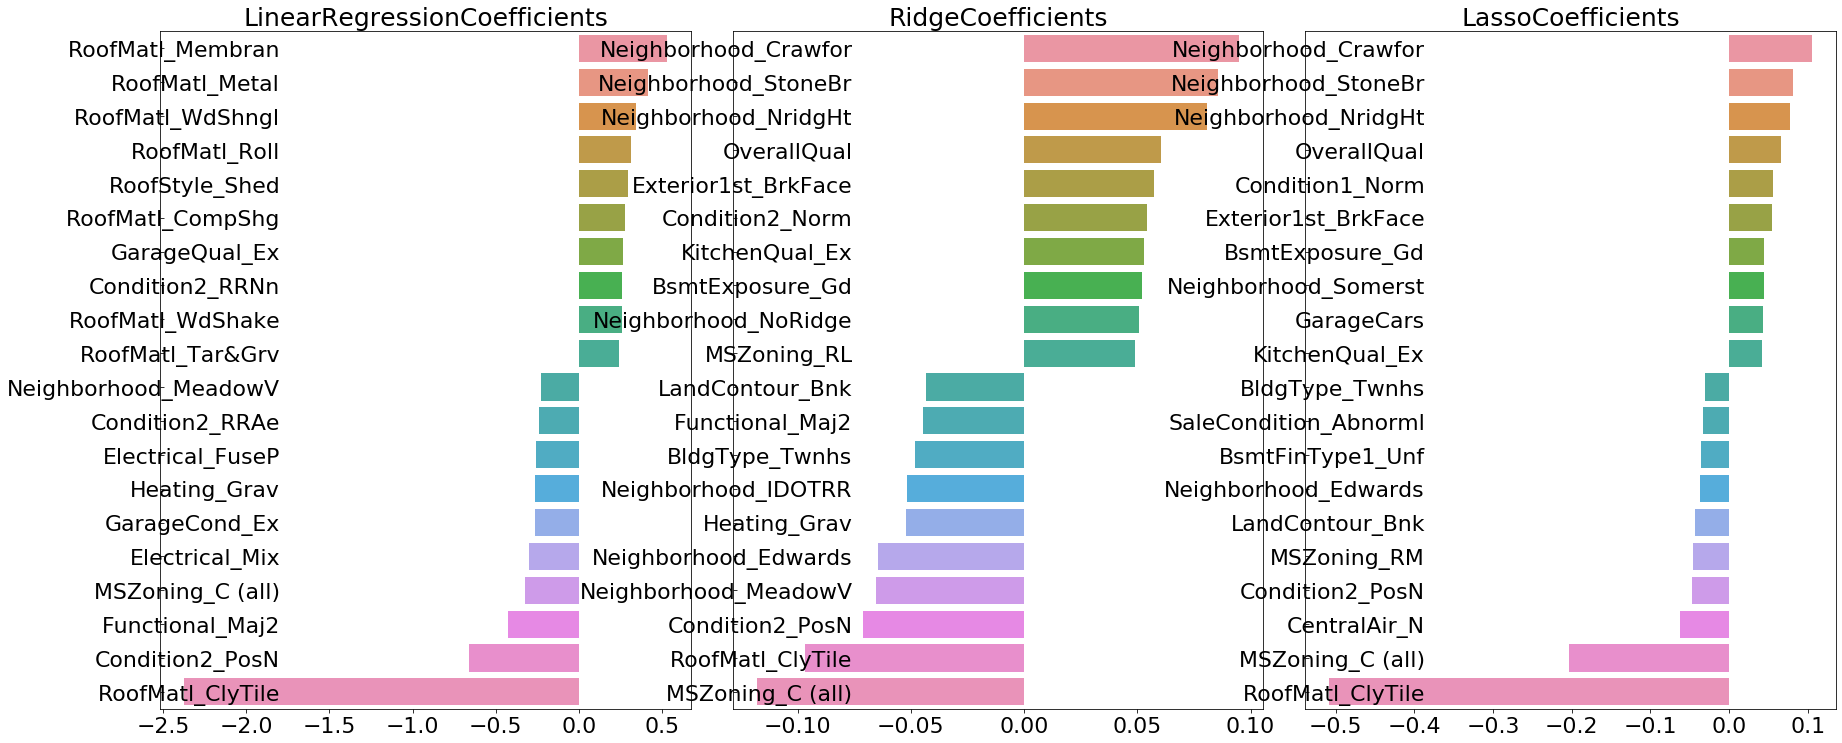

In [15]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

In [16]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew()함수 호출
skew_features = house_df[features_index].apply(lambda x: skew(x))
# skew(왜곡) 정도가 1이상인 칼럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [17]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])
# 이제 다시 원핫인코딩
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)


Ridge 0.1275 {'alpha': 10}
Lasso 0.1252 {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


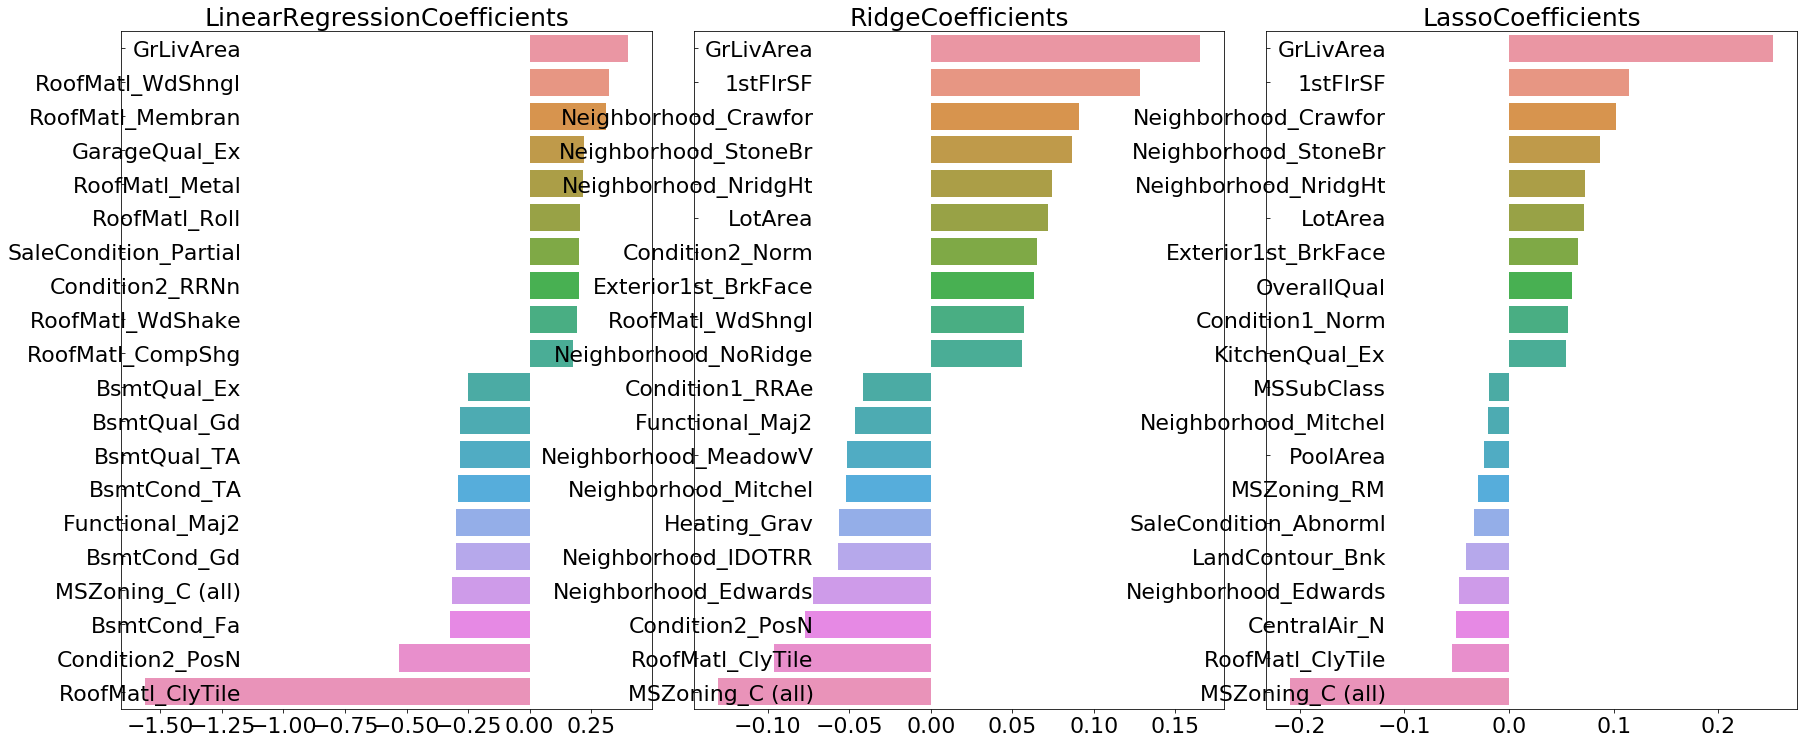

In [18]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

이제 이상치 데이터 처리

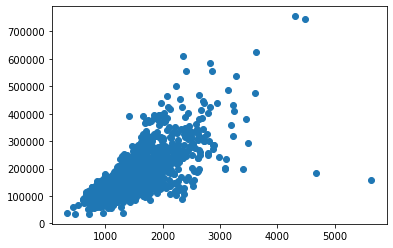

In [19]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.show()

In [20]:
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['GrLivArea'] < np.log1p(50000)
outlier_index = house_df_ohe[cond1 & cond2].index

print(outlier_index.values)
print('삭제전', house_df_ohe.shape)

house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('삭제후', house_df_ohe.shape)

[ 523  691 1182 1298]
삭제전 (1460, 271)
삭제후 (1456, 271)


In [21]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha' : [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha' : [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)


Ridge 0.1125 {'alpha': 8}
Lasso 0.1121 {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.117
Lasso 로그 변환된 RMSE: 0.116


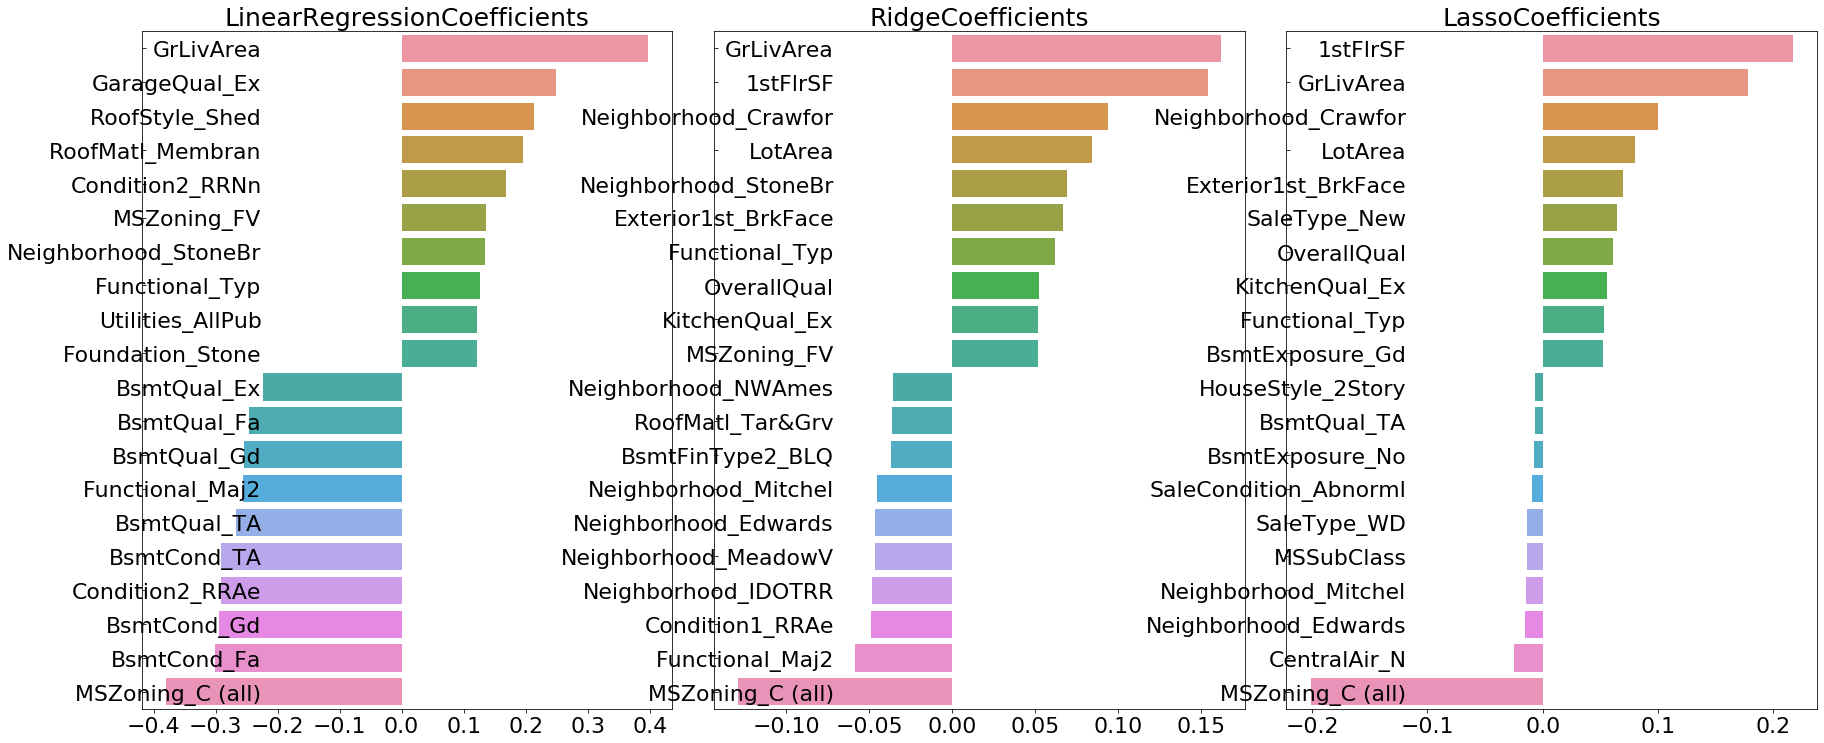

In [22]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

In [23]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                      colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

[10:46:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:46:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:47:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 0.1

In [24]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                        subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 0.1157 {'n_estimators': 1000}


### ridge랑 lasso를 섞어보자

In [25]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print(key, rmse)
        
        
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합' : pred,
        'Ridge' : ridge_pred,
        'Lasso' : lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE값 출력
get_rmse_pred(preds)

최종 혼합 0.1152659869081283
Ridge 0.11736730851679043
Lasso 0.11586584411875048


### lightgbm과 XGBoost를 섞어보자

In [26]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                      colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05,
                        num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합' : pred,
        'XGB' : xgb_pred,
        'LGBM' : lgbm_pred}

get_rmse_pred(preds)

[10:47:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합 0.11588187618406896
XGB 0.11883828073932295
LGBM 0.11806601740834839


### Stacking model

In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트:', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        # 입력된 원본 데스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

# get_stacking_base_datasets()은 넘파이 ndarray를 인자로 사용하므로 dataframe을 넘파이로 변환.
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(base) 모델이 생ㅅ어한 학습용/테스트용 데이터 반환.
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

# 개별 모델이 반환한 학습 및 데스트용 데이터 세트를 스태킹 형태로 결합.
Stack_final_X_train = np.concatenate((ridge_train, lasso_train,
                                     xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test,
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용.
meta_model_lasso = Lasso(alpha=0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE값은:', rmse)

Ridge model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
Lasso model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
XGBRegressor model 시작
	 폴드 세트: 0 시작
[10:59:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트: 1 시작
[10:59:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트: 2 시작
[10:59:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트: 3 시작
[10:59:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트: 4 시작
[10:59:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/